<h1><strong><u>Assignment 5</u></strong></h1>

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import spacy

<h2><u>Data Preprocessing</u></h2>

In [4]:
df = pd.DataFrame(columns=["title", "target"])

In [5]:
# Formatting text files
titles = []
targets = []
file_path_dict = {'clickbait': './clickbait_data.txt', 'non clickbait': './non_clickbait_data.txt'}
for key, value in file_path_dict.items():
    with open(value, 'r') as file:
        for line_number, line in enumerate(file):
            line = line.strip()
            if line != "":
                titles.append(line)
                targets.append(key)
data_dict = {"title": titles, "target": targets}
df = pd.DataFrame(data_dict)


In [6]:
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
display(data)

,title,target
0,Filipino activist arrested for disrupting Mani...,non clickbait
1,"International Board fixes soccer field size, h...",non clickbait
2,24 Rules For Women On A First Date With A Man,clickbait
3,Political fallout from the sacking of Professo...,non clickbait
4,"Which ""Clueless"" Character Are You Based On Yo...",clickbait
...,...,...
31995,Rocket strike near hotel in Afghan capital inj...,non clickbait
31996,How Well Do You Remember The First Episode Of ...,clickbait
31997,16 Photos From The Delhi Queer Pride Parade Th...,clickbait
31998,33 Of The Most Canadian Sentences Ever,clickbait


In [7]:
X = data.drop("target", axis=1)
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(25600, 1)

(6400, 1)

(25600,)

(6400,)

<h2><u>Data Vectorization</u></h2>

In [8]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

In [9]:
tdidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X_train_tfidf_vectorized = tdidf_vectorizer.fit_transform(X_train['title'])
tdidf_vectorizer.get_feature_names_out()
X_test_tfidf_vectorized = tdidf_vectorizer.transform(X_test['title'])

In [10]:
display(X_train_tfidf_vectorized.shape)
display(X_test_tfidf_vectorized.shape)

(25600, 23919)

(6400, 23919)

<h2><strong><u>Main Model Selection by Cross Validation Testing</u></strong></h2>

<h3><strong><u>K-Nearest Neighbors Model Selection</u></strong></h3>

<h4><u>Cross Validation Testing</u></h4>

In [9]:
pipeline = Pipeline(
    [
        ("clf", KNeighborsClassifier())
    ]
)
param_grid = {
    "clf__n_neighbors": [51, 53, 55, 57, 59],
    "clf__weights": ["uniform", "distance"]
}

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train_tfidf_vectorized, y_train)
model.best_params_

{'clf__n_neighbors': 51, 'clf__weights': 'distance'}

In [17]:
knn_classifier = KNeighborsClassifier(n_neighbors=53, weights='distance')
knn_classifier.fit(X_train_tfidf_vectorized, y_train)

KNeighborsClassifier(n_neighbors=53, weights='distance')

In [11]:
metrics = {'Accuracy': 'accuracy', 'Precision (Macro)': 'precision_macro', 'Recall (Macro)': 'recall_macro'}

<h4><u>K-Nearest Neighbors Training Metrics</u></h4>

In [18]:
knn_training_values = cross_val_score(knn_classifier, X_train_tfidf_vectorized, y_train, scoring='accuracy', cv=5)
print(f"Cross-validation Accuracy training scores: ", knn_training_values)
np_knn_training_values = np.array(knn_training_values)
average = np.mean(np_knn_training_values)
stDev = np.std(np_knn_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.92636719 0.92792969 0.92246094 0.92421875 0.92558594]
0.93  +/-  0.0019 



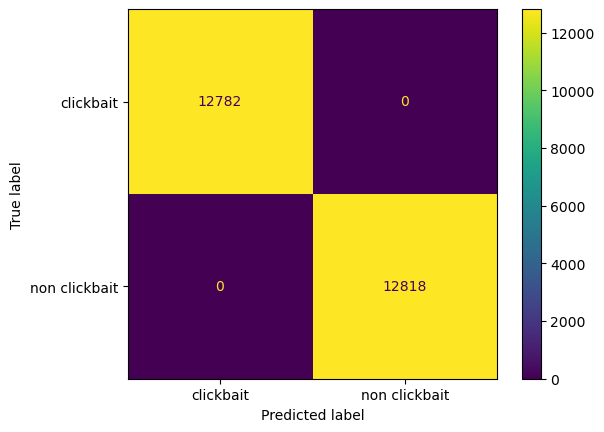

In [13]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_train_tfidf_vectorized, y_train)

<h4><u>K-Nearest Neighbors Testing Metrics</u></h4>

In [19]:
knn_training_values = cross_val_score(knn_classifier, X_test_tfidf_vectorized, y_test, scoring='accuracy', cv=5)
print(f"Cross-validation Accuracy training scores: ", knn_training_values)
np_knn_training_values = np.array(knn_training_values)
average = np.mean(np_knn_training_values)
stDev = np.std(np_knn_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.88359375 0.8890625  0.89296875 0.89296875 0.89453125]
0.89  +/-  0.004 



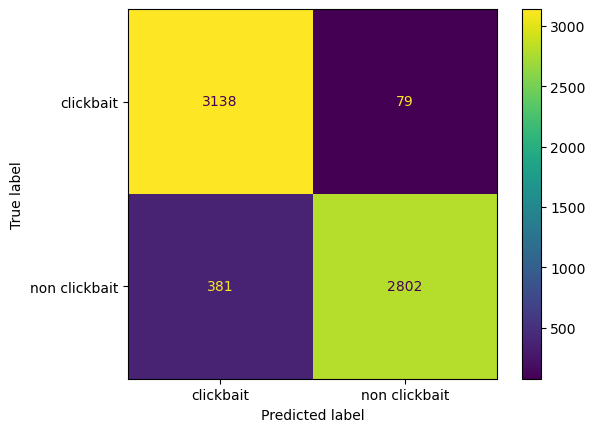

In [15]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_test_tfidf_vectorized, y_test)

<h4><u>K-Nearest Neighbors Learning Curves</u></h4>

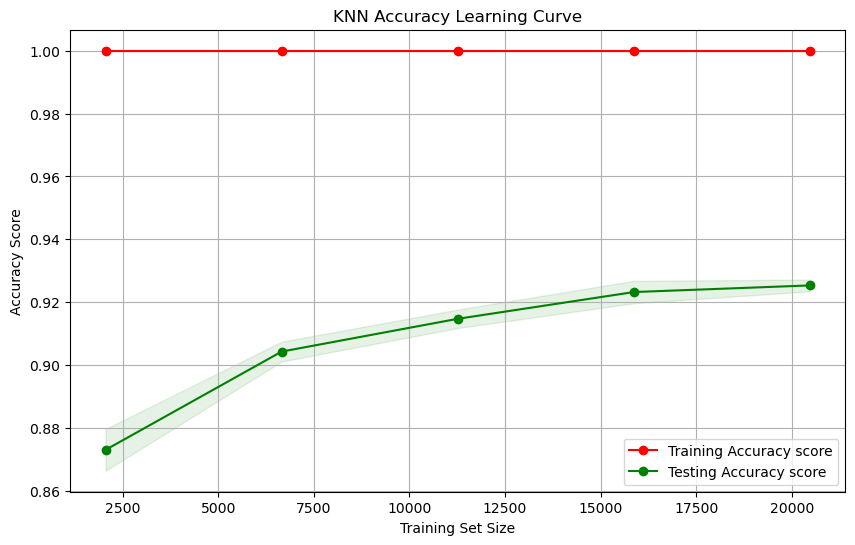

In [20]:
knn_train_sizes, knn_train_scores, knn_test_scores = learning_curve(
    knn_classifier,
    X_train_tfidf_vectorized,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
knn_train_scores_mean = np.mean(knn_train_scores, axis=1)
knn_train_scores_std = np.std(knn_train_scores, axis=1)
knn_test_scores_mean = np.mean(knn_test_scores, axis=1)
knn_test_scores_std = np.std(knn_test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("KNN Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(knn_train_sizes, knn_train_scores_mean - knn_train_scores_std,
                knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(knn_train_sizes, knn_test_scores_mean - knn_test_scores_std,
                knn_test_scores_mean + knn_test_scores_std, alpha=0.1,
                color="g")
plt.plot(knn_train_sizes, knn_train_scores_mean, 'o-', color="r",
            label="Training Accuracy score")
plt.plot(knn_train_sizes, knn_test_scores_mean, 'o-', color="g",
            label="Testing Accuracy score")

plt.legend(loc="best")
plt.show()

<h3><strong><u>Naive Bayes Model Selection</u></strong></h3>

<h4><u>Cross Validation Testing</u></h4>

In [17]:
pipeline = Pipeline(
    [
        ("clf", None)
    ]
)
param_grid = [
    {"clf": [ComplementNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [MultinomialNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [GaussianNB()]},
    {"clf": [CategoricalNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]},
    {"clf": [BernoulliNB()], "clf__alpha": [0.05, 0.1, 0.5, 1.0]}
    ]

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train_tfidf_vectorized, y_train)
model.best_params_

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 85.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.

{'clf': BernoulliNB(), 'clf__alpha': 0.1}

In [21]:
nb_classifier = BernoulliNB(alpha=0.1)
nb_classifier.fit(X_train_tfidf_vectorized, y_train)

BernoulliNB(alpha=0.1)

<h4><u>Naive Bayes Training Metrics</u></h4>

In [22]:
nb_training_values = cross_val_score(nb_classifier, X_train_tfidf_vectorized, y_train, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.95878906 0.96035156 0.96132812 0.95761719 0.95957031]
0.96  +/-  0.0013 



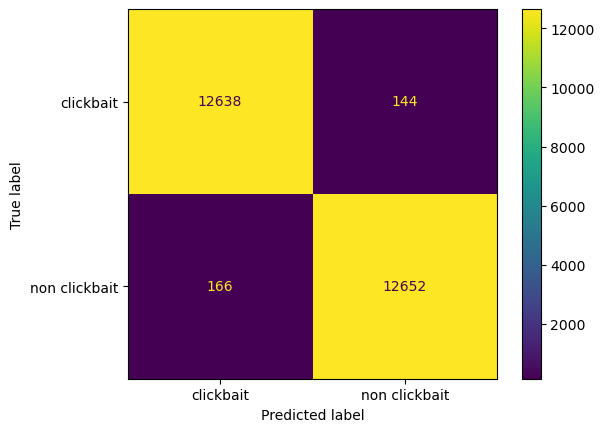

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_train_tfidf_vectorized, y_train)

<h4><u>Naive Bayes Testing Metrics</u></h4>

In [24]:
nb_training_values = cross_val_score(nb_classifier, X_test_tfidf_vectorized, y_test, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.94765625 0.93359375 0.9328125  0.953125   0.95234375]
0.94  +/-  0.0089 



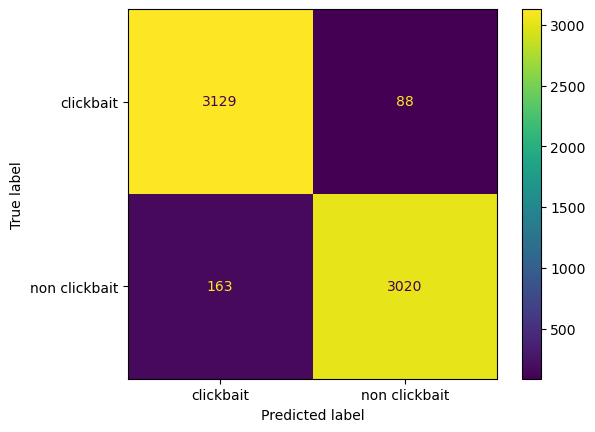

In [22]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_classifier, X_test_tfidf_vectorized, y_test)

<h4><u>Naive Bayes Learning Curves</u></h4>

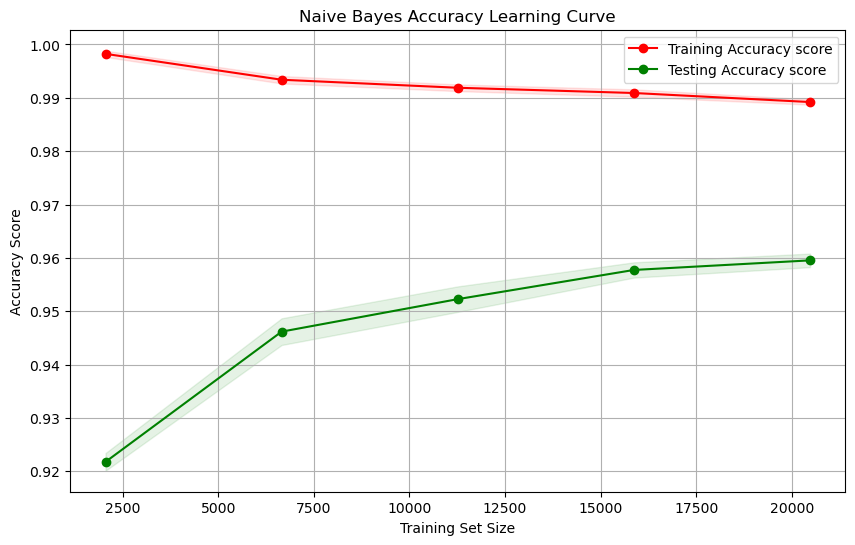

In [25]:
nb_train_sizes, nb_train_scores, nb_test_scores = learning_curve(
    nb_classifier,
    X_train_tfidf_vectorized,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
nb_train_scores_mean = np.mean(nb_train_scores, axis=1)
nb_train_scores_std = np.std(nb_train_scores, axis=1)
nb_test_scores_mean = np.mean(nb_test_scores, axis=1)
nb_test_scores_std = np.std(nb_test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Naive Bayes Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(nb_train_sizes, nb_train_scores_mean - nb_train_scores_std,
                nb_train_scores_mean + nb_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(nb_train_sizes, nb_test_scores_mean - nb_test_scores_std,
                nb_test_scores_mean + nb_test_scores_std, alpha=0.1,
                color="g")
plt.plot(nb_train_sizes, nb_train_scores_mean, 'o-', color="r",
            label="Training Accuracy score")
plt.plot(nb_train_sizes, nb_test_scores_mean, 'o-', color="g",
            label="Testing Accuracy score")

plt.legend(loc="best")
plt.show()

<h3><strong><u>Multilayered Perceptron Model Selection</u></strong></h3>

<h4><u>Cross Validation Testing</u></h4>

In [ ]:
pipeline = Pipeline(
    [
        ("clf", MLPClassifier(max_iter=2000, random_state=42)),
    ]
)
param_grid = {
    "clf__hidden_layer_sizes": [(10, ), (20, ), (40, ), (80, ), (10, 2), (20, 2), (40, 2), (60, 2), (80, 2), (100, 2)]
    }

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train_tfidf_vectorized, y_train)
model.best_params_

{'clf__hidden_layer_sizes': (20,)}

Exception ignored in: <function ResourceTracker.__del__ at 0x1040adbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1027cdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1030c9bc0>
Traceback (most recent call last

In [ ]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(20, ), max_iter=2000, random_state=42)
mlp_classifier.fit(X_train_tfidf_vectorized, y_train)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=2000, random_state=42)

<h4><u>Multi-Layered Perceptron Training Metrics</u></h4>

In [ ]:
mlp_training_values = cross_val_score(mlp_classifier, X_train_tfidf_vectorized, y_train, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", mlp_training_values)
np_mlp_training_values = np.array(mlp_training_values)
average = np.mean(np_mlp_training_values)
stDev = np.std(np_mlp_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.95488281 0.95292969 0.95332031 0.94804687 0.95703125]
0.95  +/-  0.003 



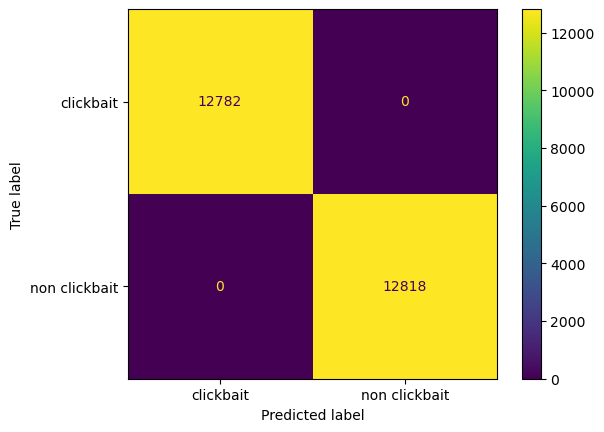

In [ ]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_train_tfidf_vectorized, y_train)

<h4><u>Multi-Layered Perceptron Testing Metrics</u></h4>

In [ ]:
mlp_training_values = cross_val_score(mlp_classifier, X_test_tfidf_vectorized, y_test, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", mlp_training_values)
np_mlp_training_values = np.array(mlp_training_values)
average = np.mean(np_mlp_training_values)
stDev = np.std(np_mlp_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.9390625 0.9328125 0.9265625 0.934375  0.94375  ]
0.94  +/-  0.0058 



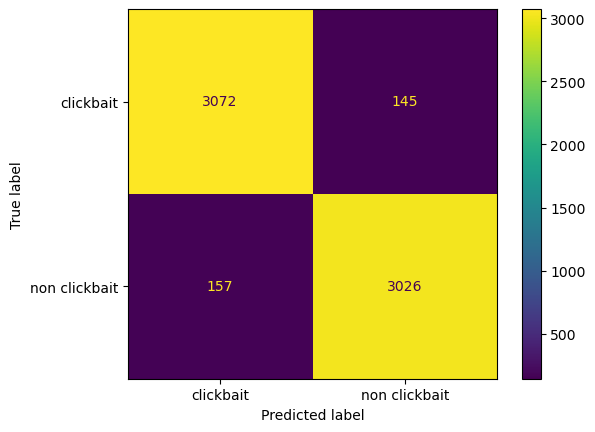

In [ ]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_test_tfidf_vectorized, y_test)

<h4><u>Multi-Layered Perceptron Learning Curves</u></h4>

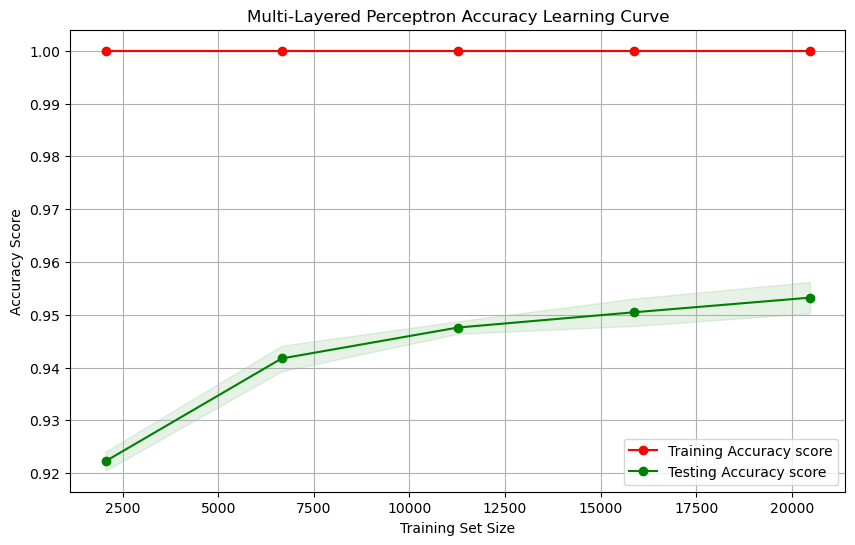

Exception ignored in: <function ResourceTracker.__del__ at 0x104ef5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106dc1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1038d9bc0>
Traceback (most recent call last

In [ ]:
mlp_train_sizes, mlp_train_scores, mlp_test_scores = learning_curve(
    mlp_classifier,
    X_train_tfidf_vectorized,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
mlp_train_scores_mean = np.mean(mlp_train_scores, axis=1)
mlp_train_scores_std = np.std(mlp_train_scores, axis=1)
mlp_test_scores_mean = np.mean(mlp_test_scores, axis=1)
mlp_test_scores_std = np.std(mlp_test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Multi-Layered Perceptron Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(mlp_train_sizes, mlp_train_scores_mean - mlp_train_scores_std,
                mlp_train_scores_mean + mlp_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(mlp_train_sizes, mlp_test_scores_mean - mlp_test_scores_std,
                mlp_test_scores_mean + mlp_test_scores_std, alpha=0.1,
                color="g")
plt.plot(mlp_train_sizes, mlp_train_scores_mean, 'o-', color="r",
            label="Training Accuracy score")
plt.plot(mlp_train_sizes, mlp_test_scores_mean, 'o-', color="g",
            label="Testing Accuracy score")

plt.legend(loc="best")
plt.show()

<h3><u>Main Model Cross-Validation Test</u></h3>

In [ ]:
pipeline = Pipeline(
    [
        ("clf", None)
    ]
)
param_grid = [
    {"clf": [KNeighborsClassifier()], "clf__n_neighbors": [51], "clf__weights": ["distance"]},
    {"clf": [BernoulliNB()], "clf__alpha": [0.1]},
    {"clf": [MLPClassifier()], "clf__hidden_layer_sizes": [(20, )], "clf__max_iter": [2000]},
    ]

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train_tfidf_vectorized, y_train)
model.best_params_

{'clf': BernoulliNB(), 'clf__alpha': 0.1}

Exception ignored in: <function ResourceTracker.__del__ at 0x10533dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1069f9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10348dbc0>
Traceback (most recent call last

<h2><u>Results</u></h2>

<ol>
<li>What data representation did you use?</li>
<p></p></br>
<li>What metric did you select to rank the models?</li>
<p></p></br>
<li>How did each model score on the selected metric for both the training data and the testing data?</li>
<p></p></br>
<li>What hyperparameter values gave the optimal results in the cross validation?</li>
<p></p></br>
<li>Describe a way in which the classifier could be used as a plugin for a web browser.</li>
<p></p></br>
</ol>